In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
import torch
from tqdm import tqdm
from random import random
import matplotlib.colors as mcolors
import matplotlib.cm as cm

#sns darkgrid
sns.set_style("darkgrid")

%matplotlib inline
%cd /net/pulsar/home/koes/jok120/openfold

RESULTS_BASE_DIRS = ["/net/pulsar/home/koes/jok120/openfold/out/evaluation/230612"]
RESULTS_BASE_DIRS += ["/net/pulsar/home/koes/jok120/openfold/out/evaluation/230609"]

/net/pulsar/home/koes/jok120/openfold


# DataFrame Setup

In [2]:
def create_dataframe_dict(eval_dirs):
    df_dict = {}
    for (model_name, basedir) in eval_dirs:
        for split in ['val', 'test']:
            for identity in ['pred', 'true', 'pred_relaxed', 'true_relaxed']:

                molpro_csv = os.path.join(basedir, model_name, "pdbs", split, identity, "molprobity.out")
                print(molpro_csv)
                molpro_df = pd.read_csv(molpro_csv, skiprows=1, sep=":")
                molpro_df["protein_name"] = molpro_df["#pdbFileName"].str[:-12]

                # Update some molpro cols, rotaOutlier:rotaFavored:numRota:ramaOutlier:ramaAllowed:ramaFavored:numRama
                #pct_badbonds, pct_badangles
                molpro_df["percentRamaFavored"] = molpro_df["ramaFavored"] / molpro_df["numRama"] * 100
                molpro_df["percentRotaFavored"] = molpro_df["rotaFavored"] / molpro_df["numRota"] * 100
                molpro_df["percentRamaAllowed"] = molpro_df["ramaAllowed"] / molpro_df["numRama"] * 100
                molpro_df["percentRamaOutlier"] = molpro_df["ramaOutlier"] / molpro_df["numRama"] * 100
                molpro_df["percentRotaOutlier"] = molpro_df["rotaOutlier"] / molpro_df["numRota"] * 100
                if 'relaxed' not in identity:
                    print((model_name, split, identity))
                    df_dict[(model_name, split, identity)] = molpro_df.copy()
                    continue
                relaxation_times_df = pd.read_csv(os.path.join(basedir, model_name, "pdbs", split, identity, "relaxation_times.csv"))
                molpro_df = molpro_df.merge(relaxation_times_df, on="protein_name")
                print((model_name, split, identity))
                df_dict[(model_name, split, identity)] = molpro_df
    return df_dict

In [3]:
eval_dirs = [(subdir, basedir) for basedir in RESULTS_BASE_DIRS for subdir in os.listdir(basedir)]
print(eval_dirs)

df_dict = create_dataframe_dict(eval_dirs)
# /net/pulsar/home/koes/jok120/openfold/out/evaluation/230612/30kpure_scnmin_omm_00b_eval_sOMM/pdbs/val/pred/molprobity.out

[('30kpure_scnmin_omm_00b_eval_sOMM', '/net/pulsar/home/koes/jok120/openfold/out/evaluation/230612'), ('newbaseline_scnmin_noomm_00b_eval_sOMM', '/net/pulsar/home/koes/jok120/openfold/out/evaluation/230612'), ('finetuning_5_eval_s0', '/net/pulsar/home/koes/jok120/openfold/out/evaluation/230609')]
/net/pulsar/home/koes/jok120/openfold/out/evaluation/230612/30kpure_scnmin_omm_00b_eval_sOMM/pdbs/val/pred/molprobity.out
('30kpure_scnmin_omm_00b_eval_sOMM', 'val', 'pred')
/net/pulsar/home/koes/jok120/openfold/out/evaluation/230612/30kpure_scnmin_omm_00b_eval_sOMM/pdbs/val/true/molprobity.out
('30kpure_scnmin_omm_00b_eval_sOMM', 'val', 'true')
/net/pulsar/home/koes/jok120/openfold/out/evaluation/230612/30kpure_scnmin_omm_00b_eval_sOMM/pdbs/val/pred_relaxed/molprobity.out
('30kpure_scnmin_omm_00b_eval_sOMM', 'val', 'pred_relaxed')
/net/pulsar/home/koes/jok120/openfold/out/evaluation/230612/30kpure_scnmin_omm_00b_eval_sOMM/pdbs/val/true_relaxed/molprobity.out
('30kpure_scnmin_omm_00b_eval_sOMM

# Defs

In [4]:
# Compare baseline times to my model times
# plt.ioff()
def make_accuracy_plot(dfx,
                       dfy,
                       dfx_name,
                       dfy_name,
                       dataset_split,
                       metric="gdcall_aa",
                       hue="",
                       hue_is_y=True,
                       hue_is_yraw=False,
                       use_log=False,
                       use_cube_root=False,
                       alpha=1,
                       size=3,
                       ax=None,
                       index=0,
                       save_prefix="",
                       fig=None,
                    #    label_energy_df=get_label_energy_df(),
                       scale_hue=1,
                       ):
    """Make a scatter plot with seaborn comparing methods dfx and dfy on metric.
    Each row of the dataframes correspond to a different protein. For each protein,
    plot a point on the scatter plot with x-value equal to the metric value for dfx
    and y-value equal to the metric value for dfy.
    First join the dataframes on the protein column using suffixes to rename duplicate cols,
    then plot the metric values for each method.
    """
    

    df = dfx.merge(dfy, on="protein_name", suffixes=(f"_{dfx_name}", f"_{dfy_name}"))


    xmetric = f"{metric}_{dfx_name}"
    ymetric = f"{metric}_{dfy_name}"

    # determine the min and max values over the x and y axis to set the limits of the plot uniformly
    # However, add a buffer to the min and max values so that the points are not on the edge of the plot
    min_val = min(df[xmetric].min(), df[ymetric].min())
    max_val = max(df[xmetric].max(), df[ymetric].max())
    # Add a buffer to the min and max values
    buffer = 0.05 * (max_val - min_val)
    min_val -= buffer
    max_val += buffer
    
    if ax is None and hue is not "":
        fig, ax = plt.subplots(figsize=(size*1.15, size));
    elif ax is None:
        fig, ax = plt.subplots(figsize=(size*1, size));

    # Set the appropriate x and y axis limits using the fig and ax variables
    # Use the min and max values calculated above

    # make sure no limit is nan or inf
    if not np.isnan(min_val) and not np.isinf(min_val):
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
    
    # plot a dotted line y=x on the same figure without displaying it
    ax.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="black", alpha=0.5);


    # if hue is not empty, use it to color the points
    if hue:
        # Use coolwarm colormap, with negative values being red and positive values being blue
        if hue_is_yraw:
            name = hue
        elif hue_is_y:
            name = f"{hue}_{dfy_name}"
        else:
            name = f"{hue}_{dfx_name}"
        try:
            vals = df[name] / scale_hue
        except KeyError:
            print(f"{name} not found in df")
            print(df.columns)
            return
        if 'energy' in hue or 'openmm' in hue:
            vmin, vmax = vals.min(), vals.max()
            vcenter = 0
            if vmin > 0:
                vcenter = vmin + 1e-6

        else:
            vmin = 0
            vmax = 1
            vcenter = 0.5
        assert (vmin < vcenter < vmax), f"{name}: Must have vmin < vcenter < vmax, but got vmin: {vmin}, vcenter: {vcenter}, vmax: {vmax}"
        print(f"vmin: {vmin}, vmax: {vmax}, vcenter: {vcenter}")

        normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap='coolwarm' if vcenter == 0 or 'pct' not in hue or 'percent' not in hue else 'Blues')
        scalarmappaple.set_array(vals)
        plt.colorbar(scalarmappaple, label=name)


    if hue and hue_is_yraw:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, hue=hue, ax=ax, alpha=alpha, palette='coolwarm' if vcenter == 0 else 'Blues', norm=normalize);
    elif hue and hue_is_y:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, hue=f"{hue}_{dfy_name}", ax=ax, alpha=alpha, palette='coolwarm' if vcenter == 0 else 'Blues');
    elif hue and not hue_is_y:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, hue=f"{hue}_{dfx_name}", ax=ax, alpha=alpha);
    else:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, ax=ax, alpha=alpha);


    # Get the mean values for each method
    dfx_mean = df[xmetric].mean()
    dfy_mean = df[ymetric].mean()

    # Set the position of the box
    ax.text(
        0.05,
        0.95,
        f"y mean: {dfy_mean:.3f}\nx mean: {dfx_mean:.3f}\ny-x: {dfy_mean - dfx_mean:.4f}\ny std: {df[ymetric].std():.2f}\nx std: {df[xmetric].std():.2f}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        bbox=dict(boxstyle="square", facecolor="white", alpha=0.5),
    )

    plt.xlabel(f"{dfx_name}");
    plt.ylabel(f"{dfy_name}");
    plt.title(f"{metric} : {dataset_split}");

    if hue is not "":
        ax.get_legend().remove()

    # Ensure a white background
    if fig:
        fig.patch.set_facecolor('white')

    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")
    

    

    # Return the plot
    return ax




<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:127: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:127: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_2824761/3907786202.py:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if ax is None and hue is not "":
/tmp/ipykernel_2824761/3907786202.py:127: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if hue is not "":


In [5]:
def make_barplot(dfx, dfy, dfx_name, dfy_name, metric, dataset_split, hue=None, hue_is_y=False,
                  alpha=0.9, size=4, save_prefix=None, index=0, fliers=False, dotsize=3):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(size*1.15, size));

    # Concatenate the two dataframes
    df = pd.concat([dfx, dfy])

    # Add a column to the dataframe to indicate the source of each row
    df["source"] = [dfx_name] * len(dfx) + [dfy_name] * len(dfy)

    # Plot the barplot
    sns.boxplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], ax=ax, showfliers=fliers);
    sns.swarmplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], alpha=alpha, ax=ax, color='black', size=dotsize);

    # Set the y axis label to be the metric
    plt.ylabel(metric);

    # Set the title of the plot to be the metric and the dataset split
    plt.title(f"{metric} : {dataset_split}");

    # Rotate the entire plot 
    plt.xticks(rotation=20);


    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")

    # Return the plot
    return ax


def make_3barplot(dfx, dfy, dfz, dfx_name, dfy_name, dfz_name, metric, dataset_split, hue=None, hue_is_y=False,
                  alpha=0.9, size=4, save_prefix=None, index=0, fliers=False, dotsize=3):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(size*1.15, size));

    # Concatenate the two dataframes
    df = pd.concat([dfx, dfy, dfz])

    # Add a column to the dataframe to indicate the source of each row
    df["source"] = [dfx_name] * len(dfx) + [dfy_name] * len(dfy) + [dfz_name] * len(dfz)

    # Plot the barplot
    sns.boxplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], ax=ax, showfliers=fliers);
    sns.swarmplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], alpha=alpha, ax=ax, color='black', size=dotsize);

    # Set the y axis label to be the metric
    plt.ylabel(metric);

    # Set the title of the plot to be the metric and the dataset split
    plt.title(f"{metric} : {dataset_split}");

    # Rotate the entire plot 
    plt.xticks(rotation=20);


    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")

    # Return the plot
    return ax

def make_nbarplot(dfs, df_names, metric, dataset_split, hue=None, hue_is_y=False,
                  alpha=0.9, size=4, save_prefix=None, index=0, fliers=False, dotsize=3):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(size*1.15, size));

    # Concatenate the two dataframes
    df = pd.concat(dfs)

    # Add a column to the dataframe to indicate the source of each row
    new_source = []
    for i, d in enumerate(dfs):
        new_source += [df_names[i]] * len(d)
    df["source"] = new_source

    # Plot the barplot
    sns.boxplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], ax=ax, showfliers=fliers);
    sns.swarmplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], alpha=alpha, ax=ax, color='black', size=dotsize);

    # Set the y axis label to be the metric
    plt.ylabel(metric);

    # Set the title of the plot to be the metric and the dataset split
    plt.title(f"{metric} : {dataset_split}");

    # Rotate the entire plot 
    plt.xticks(rotation=20);


    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")

    # Return the plot
    return ax


def make_ngroupedbarplot(dfs, df_names, metric, dataset_split, hue=None, hue_is_y=False,
                  alpha=0.9, size=4, save_prefix=None, index=0, fliers=False, dotsize=3, do_swarm=False):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(size*1.15, size));

    # Concatenate the two dataframes
    df = pd.concat(dfs)

    # Add a column to the dataframe to indicate the source of each row
    new_source = []
    for i, d in enumerate(dfs):
        new_source += [df_names[i]] * len(d)
    df["source"] = new_source
    df['is_relaxed'] = df['source'].apply(lambda x: 'relax' in x)
    df['model'] = df['source'].apply(lambda x: x.replace(' + relax', '').strip())    

    # Plot the barplot
    sns.boxplot(data=df, x=metric, y="model", hue='is_relaxed', ax=ax, showfliers=fliers);
    if do_swarm:
        sns.swarmplot(data=df, x=metric, y="model", hue=None, alpha=alpha, ax=ax, color='black', size=dotsize);

    # Set the y axis label to be the metric
    plt.ylabel(metric);

    # Set the title of the plot to be the metric and the dataset split
    plt.title(f"{metric} : {dataset_split}");

    # Rotate the entire plot 
    # plt.xticks(rotation=90);


    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")

    # Return the plot
    return ax

# Plots

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 110

In [7]:
af2 = "finetuning_5_eval_s0"
af2_scnmin = "newbaseline_scnmin_noomm_00b_eval_sOMM"
omm_scnmin = "30kpure_scnmin_omm_00b_eval_sOMM"

In [8]:
dfs = (df_dict[(af2, "test", "pred")], df_dict[(af2, "test", "pred_relaxed")],
       df_dict[(af2_scnmin, "test", "pred")], df_dict[(af2_scnmin, "test", "pred_relaxed")],
       df_dict[(omm_scnmin, "test", "pred")], df_dict[(omm_scnmin, "test", "pred_relaxed")])
df_names = ("AF2", "AF2 + relax", "AF2 + scnmin", "AF2 + scnmin + relax", "AF2 + scnmin + OMM", "AF2 + scnmin + OMM + relax")

<AxesSubplot:title={'center':'clashscore : test'}, xlabel='AF2 + relax', ylabel='AF2 + scnmin + OMM + relax'>

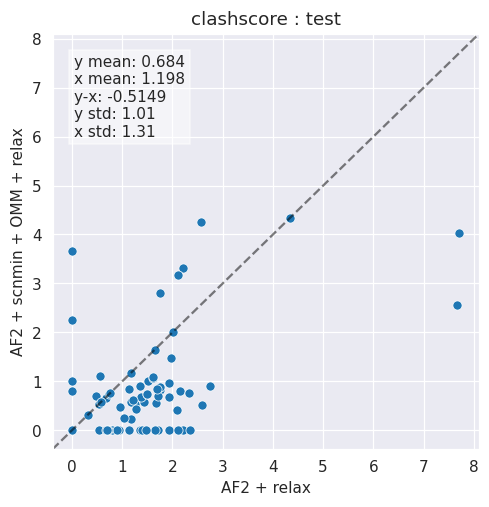

In [9]:
make_accuracy_plot(dfs[1], dfs[-1], df_names[1], df_names[-1], "test", metric='clashscore', size=5)

<AxesSubplot:title={'center':'MolProbityScore : test'}, xlabel='AF2 + relax', ylabel='AF2 + scnmin + OMM + relax'>

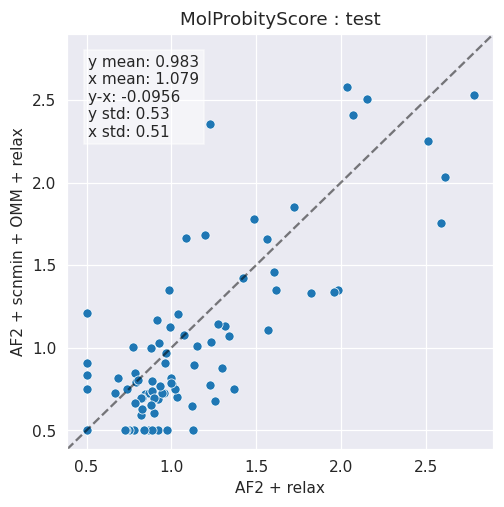

In [10]:
make_accuracy_plot(dfs[1], dfs[-1], df_names[1], df_names[-1], "test", metric='MolProbityScore', size=5)

<AxesSubplot:title={'center':'Mol_pct_rank : test'}, xlabel='AF2 + relax', ylabel='AF2 + scnmin + OMM + relax'>

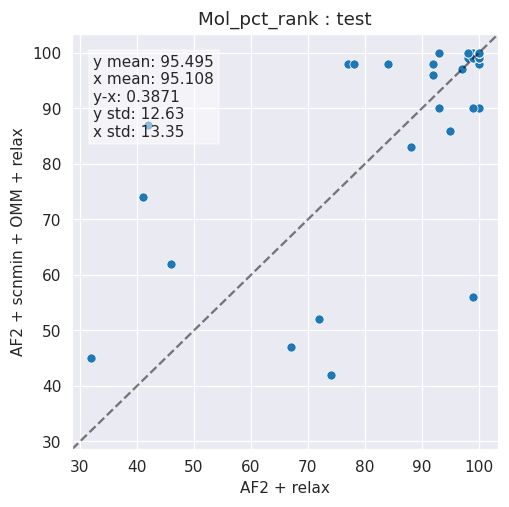

In [11]:
make_accuracy_plot(dfs[1], dfs[-1], df_names[1], df_names[-1], "test", metric='Mol_pct_rank', size=5)

<AxesSubplot:title={'center':'pct_rank : test'}, xlabel='AF2 + relax', ylabel='AF2 + scnmin + OMM + relax'>

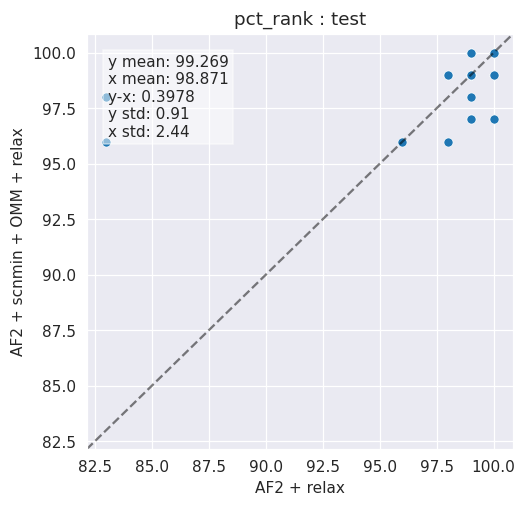

In [12]:
make_accuracy_plot(dfs[1], dfs[-1], df_names[1], df_names[-1], "test", metric='pct_rank', size=5)

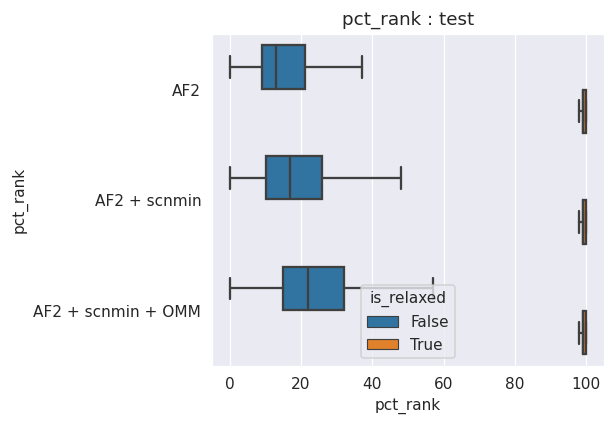

In [13]:
df = make_ngroupedbarplot(dfs, df_names, "pct_rank", "test", dotsize=3)

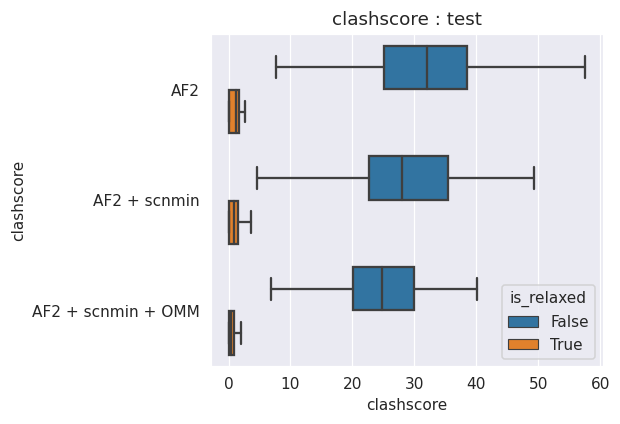

In [14]:
df = make_ngroupedbarplot(dfs, df_names, "clashscore", "test", dotsize=3)

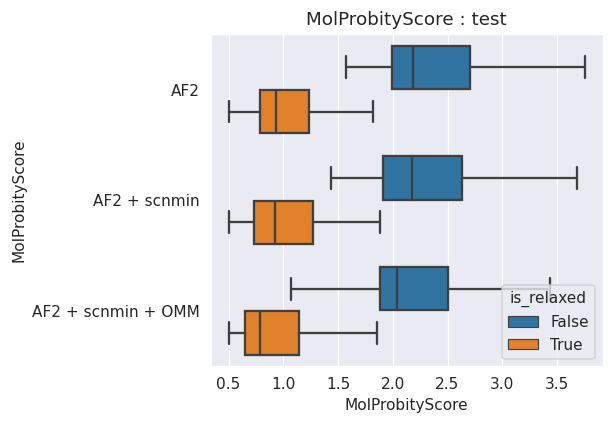

In [15]:
df = make_ngroupedbarplot(dfs, df_names, "MolProbityScore", "test", dotsize=3)

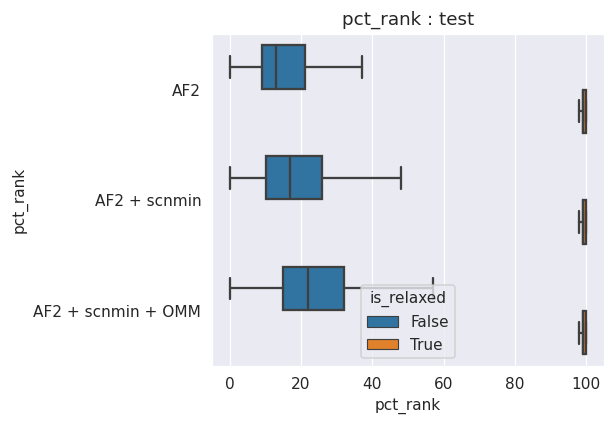

In [16]:
df = make_ngroupedbarplot(dfs, df_names, "pct_rank", "test", dotsize=3)

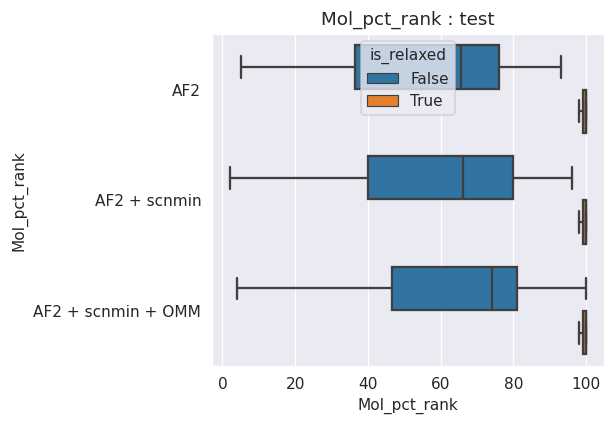

In [17]:
df = make_ngroupedbarplot(dfs, df_names, "Mol_pct_rank", "test", dotsize=3, do_swarm=False)

/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 43.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 45.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 58.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 58.1% of the points cannot be placed; you may want to decrease the 

<AxesSubplot:title={'center':'Mol_pct_rank : test'}, xlabel='source', ylabel='Mol_pct_rank'>

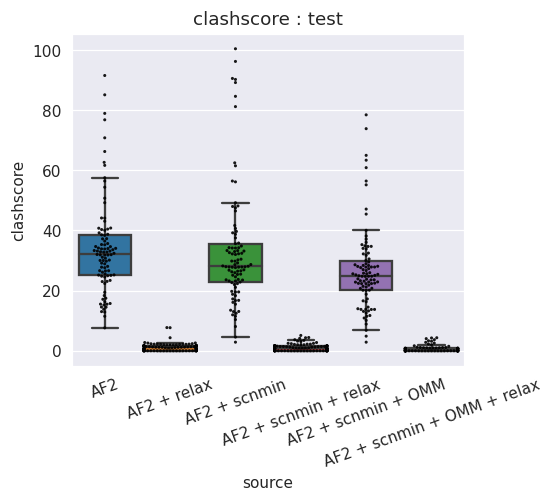

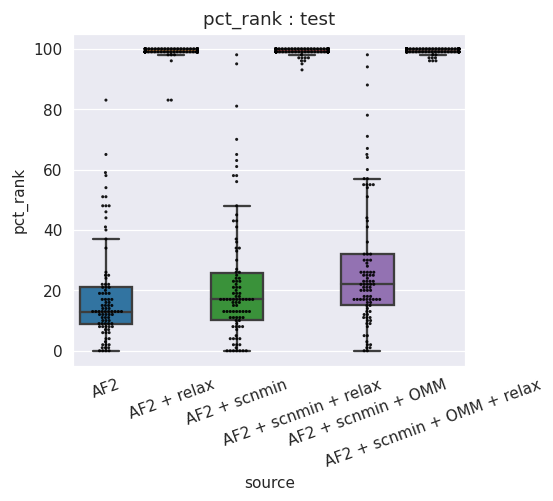

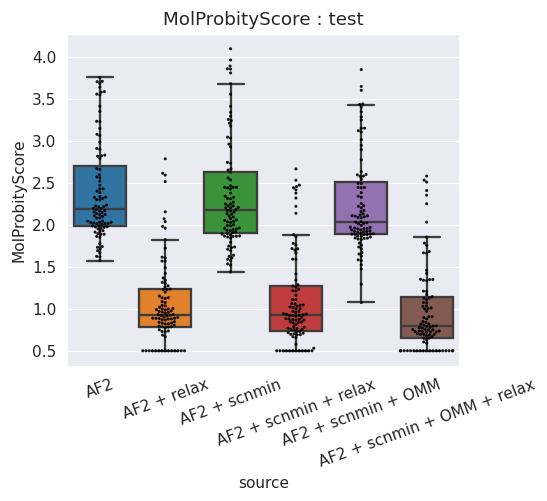

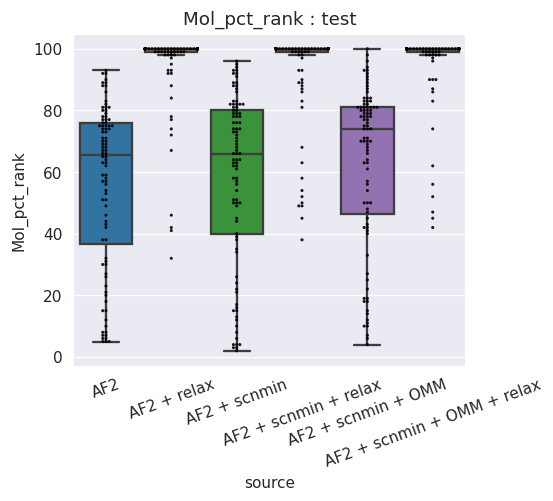

In [18]:

make_nbarplot(dfs, df_names, "clashscore", "test", dotsize=2)
make_nbarplot(dfs, df_names, "pct_rank", "test", dotsize=2)

make_nbarplot(dfs, df_names, "MolProbityScore", "test", dotsize=2)
make_nbarplot(dfs, df_names, "Mol_pct_rank", "test", dotsize=2)



/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 22.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:title={'center':'clashscore : test'}, xlabel='source', ylabel='clashscore'>

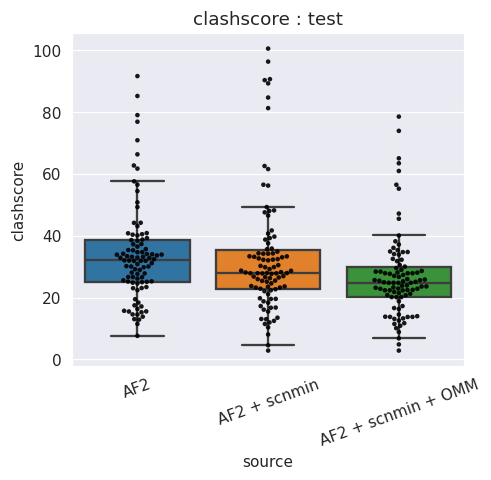

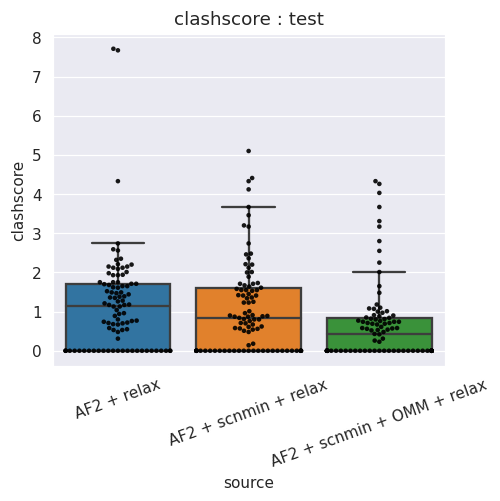

In [19]:
dfs = (df_dict[(af2, "test", "pred")], df_dict[(af2_scnmin, "test", "pred")], df_dict[(omm_scnmin, "test", "pred")])
df_names = ("AF2", "AF2 + scnmin", "AF2 + scnmin + OMM")
make_nbarplot(dfs, df_names, "clashscore", "test", dotsize=3, fliers=False)

dfs = (df_dict[(af2, "test", "pred_relaxed")], df_dict[(af2_scnmin, "test", "pred_relaxed")], df_dict[(omm_scnmin, "test", "pred_relaxed")])
df_names = ("AF2 + relax", "AF2 + scnmin + relax", "AF2 + scnmin + OMM + relax")
make_nbarplot(dfs, df_names, "clashscore", "test", dotsize=3, fliers=False)


<AxesSubplot:title={'center':'MolProbityScore : test'}, xlabel='source', ylabel='MolProbityScore'>

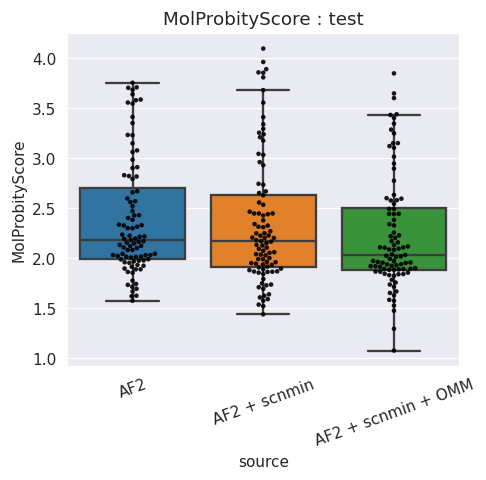

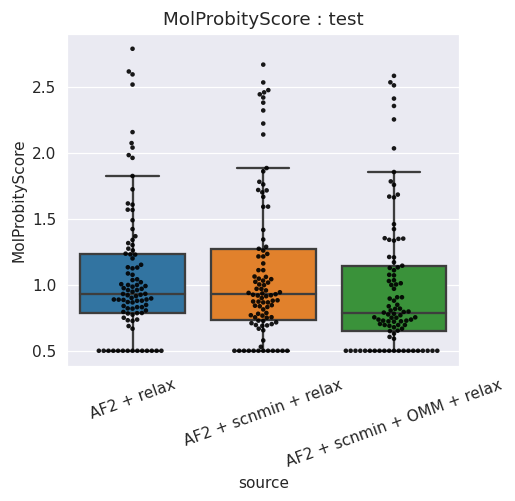

In [20]:
dfs = (df_dict[(af2, "test", "pred")], df_dict[(af2_scnmin, "test", "pred")], df_dict[(omm_scnmin, "test", "pred")])
df_names = ("AF2", "AF2 + scnmin", "AF2 + scnmin + OMM")
make_nbarplot(dfs, df_names, "MolProbityScore", "test", dotsize=3, fliers=False)

dfs = (df_dict[(af2, "test", "pred_relaxed")], df_dict[(af2_scnmin, "test", "pred_relaxed")], df_dict[(omm_scnmin, "test", "pred_relaxed")])
df_names = ("AF2 + relax", "AF2 + scnmin + relax", "AF2 + scnmin + OMM + relax")
make_nbarplot(dfs, df_names, "MolProbityScore", "test", dotsize=3, fliers=False)


/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 43.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 45.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 49.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:title={'center':'Mol_pct_rank : test'}, xlabel='source', ylabel='Mol_pct_rank'>

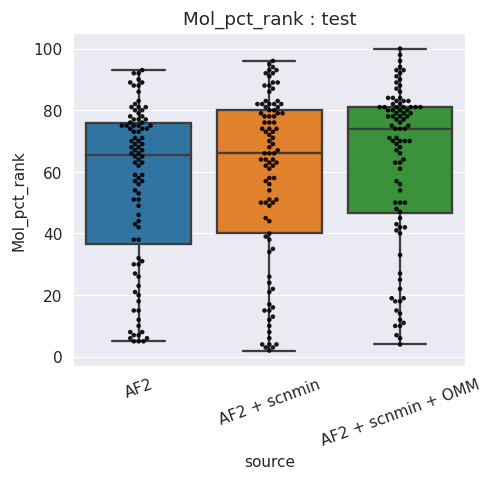

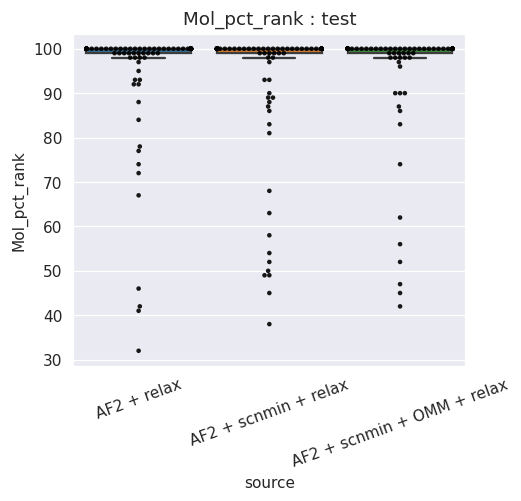

In [21]:
dfs = (df_dict[(af2, "test", "pred")], df_dict[(af2_scnmin, "test", "pred")], df_dict[(omm_scnmin, "test", "pred")])
df_names = ("AF2", "AF2 + scnmin", "AF2 + scnmin + OMM")
make_nbarplot(dfs, df_names, "Mol_pct_rank", "test", dotsize=3, fliers=False)

dfs = (df_dict[(af2, "test", "pred_relaxed")], df_dict[(af2_scnmin, "test", "pred_relaxed")], df_dict[(omm_scnmin, "test", "pred_relaxed")])
df_names = ("AF2 + relax", "AF2 + scnmin + relax", "AF2 + scnmin + OMM + relax")
make_nbarplot(dfs, df_names, "Mol_pct_rank", "test", dotsize=3, fliers=False)


/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 48.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 45.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 46.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:title={'center':'pct_rank : test'}, xlabel='source', ylabel='pct_rank'>

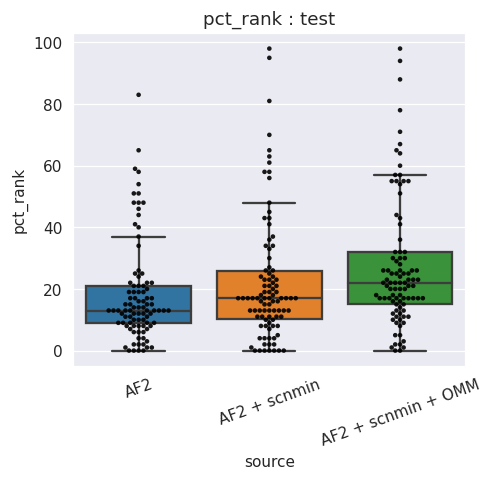

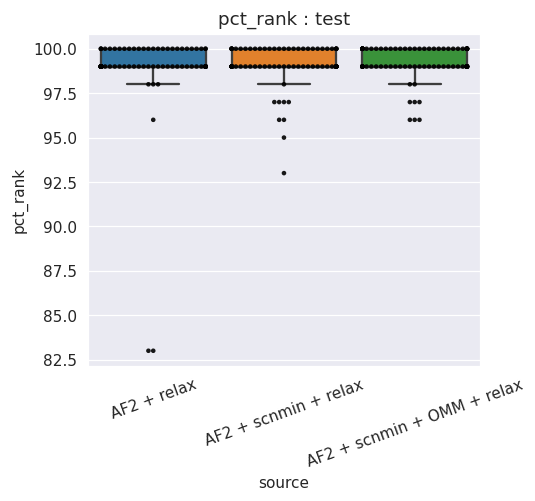

In [22]:
dfs = (df_dict[(af2, "test", "pred")], df_dict[(af2_scnmin, "test", "pred")], df_dict[(omm_scnmin, "test", "pred")])
df_names = ("AF2", "AF2 + scnmin", "AF2 + scnmin + OMM")
make_nbarplot(dfs, df_names, "pct_rank", "test", dotsize=3, fliers=False)

dfs = (df_dict[(af2, "test", "pred_relaxed")], df_dict[(af2_scnmin, "test", "pred_relaxed")], df_dict[(omm_scnmin, "test", "pred_relaxed")])
df_names = ("AF2 + relax", "AF2 + scnmin + relax", "AF2 + scnmin + OMM + relax")
make_nbarplot(dfs, df_names, "pct_rank", "test", dotsize=3, fliers=False)


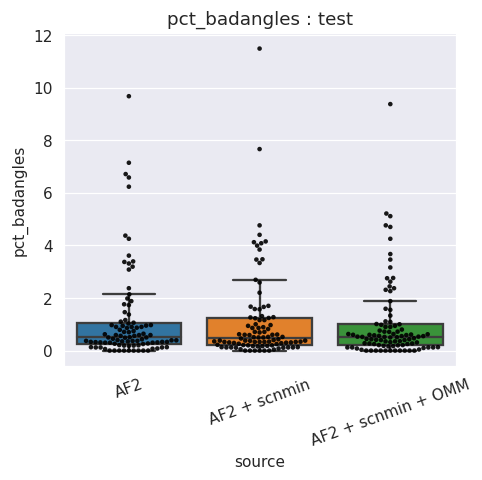

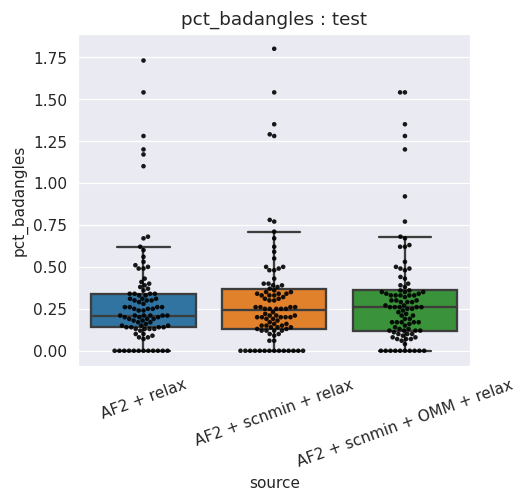

In [23]:
metric = "pct_badangles"
def make_dual_plot(metric, do_pred=True, do_pred_relaxed=True):
    if do_pred:
        dfs = (df_dict[(af2, "test", "pred")], df_dict[(af2_scnmin, "test", "pred")], df_dict[(omm_scnmin, "test", "pred")])
        df_names = ("AF2", "AF2 + scnmin", "AF2 + scnmin + OMM")
        make_nbarplot(dfs, df_names, metric, "test", dotsize=3)

    if do_pred_relaxed:
        dfs = (df_dict[(af2, "test", "pred_relaxed")], df_dict[(af2_scnmin, "test", "pred_relaxed")], df_dict[(omm_scnmin, "test", "pred_relaxed")])
        df_names = ("AF2 + relax", "AF2 + scnmin + relax", "AF2 + scnmin + OMM + relax")
        make_nbarplot(dfs, df_names, metric, "test", dotsize=3)

make_dual_plot(metric)

/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 77.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 77.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 76.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


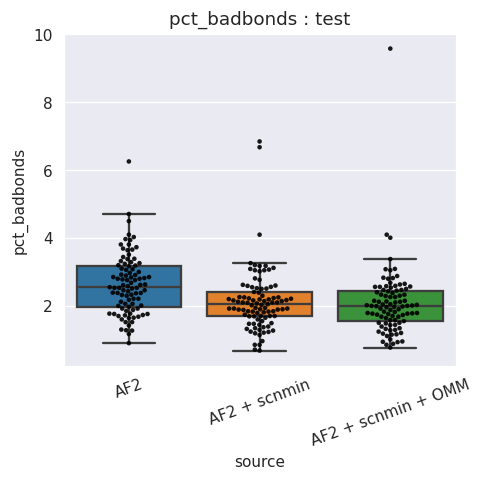

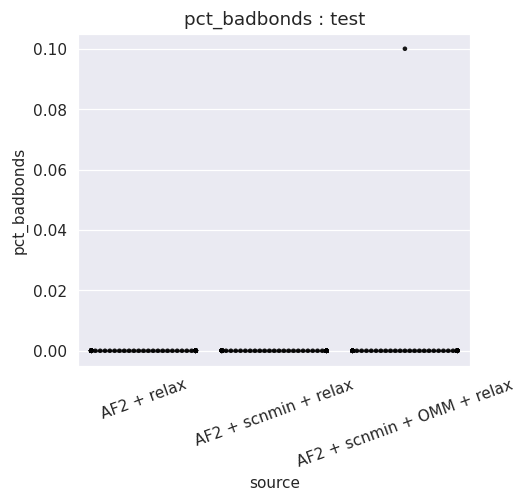

In [24]:
make_dual_plot("pct_badbonds")

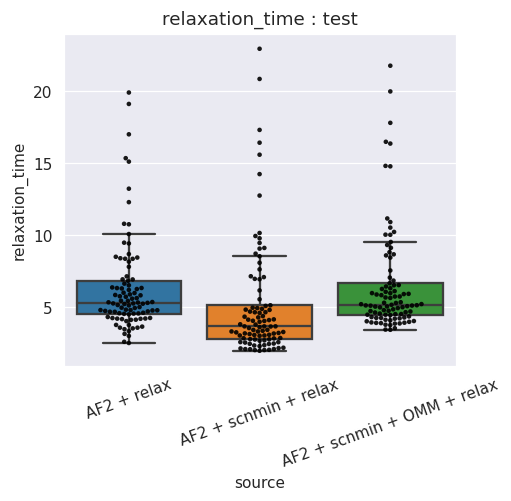

In [25]:
make_dual_plot("relaxation_time", do_pred=False)

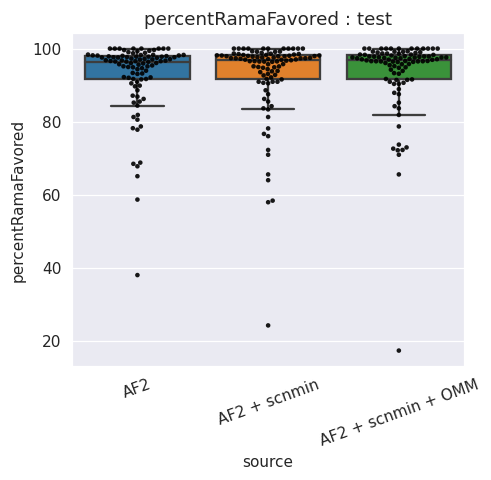

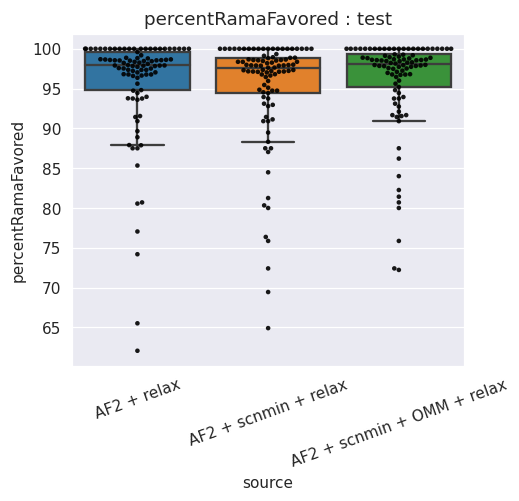

In [26]:
make_dual_plot("percentRamaFavored")

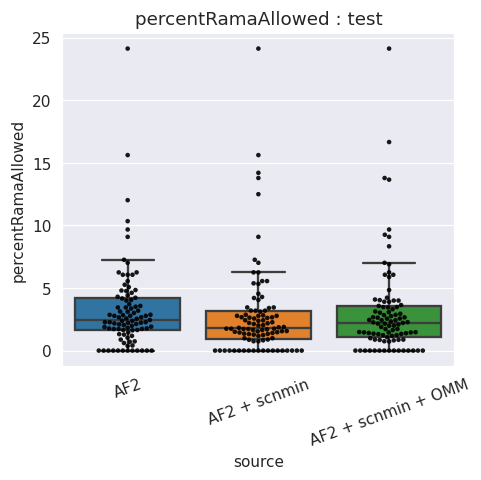

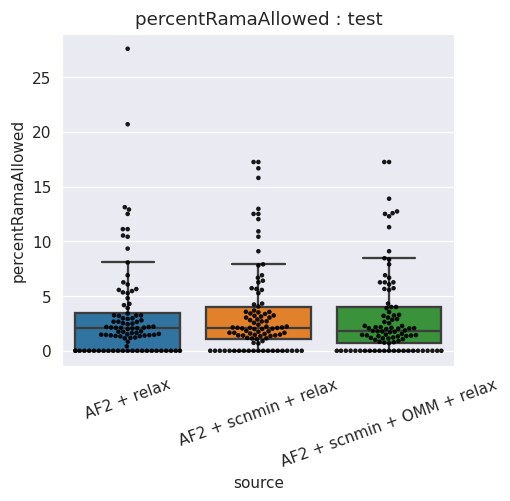

In [27]:
make_dual_plot("percentRamaAllowed")

/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 23.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 34.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 47.3% of the points cannot be placed; you may want to decrease the 

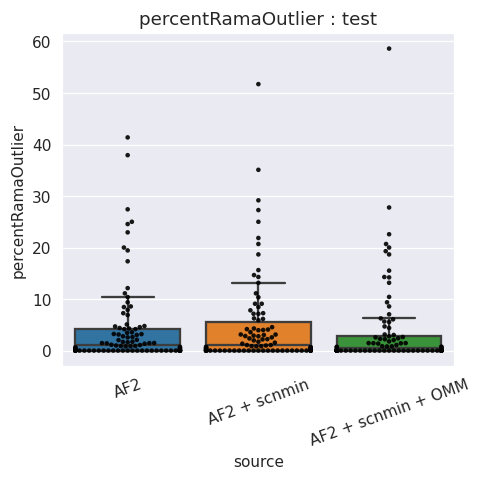

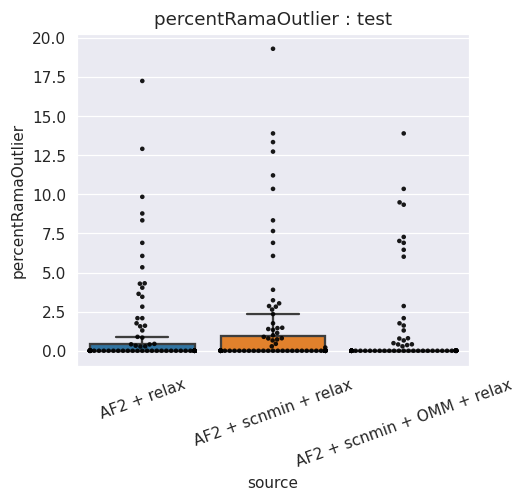

In [28]:
make_dual_plot("percentRamaOutlier")

/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


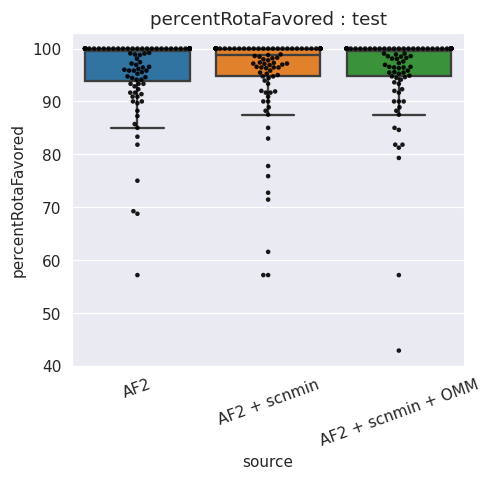

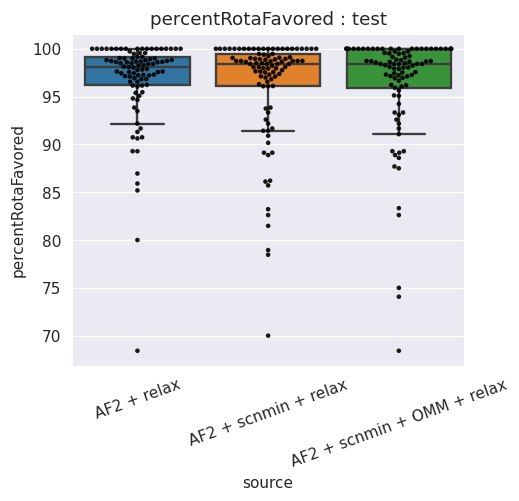

In [29]:
make_dual_plot('percentRotaFavored')

/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 58.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 51.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 54.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 37.6% of the points cannot be placed; you may want to decrease the 

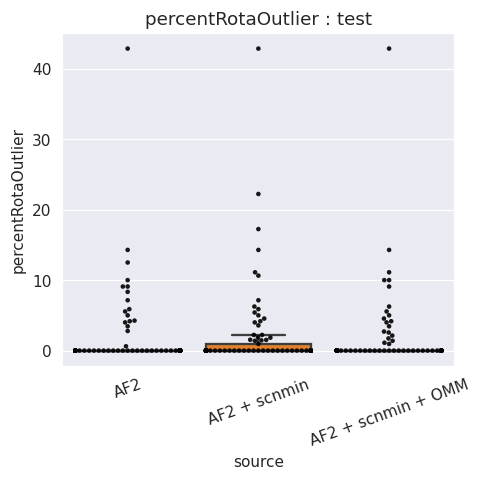

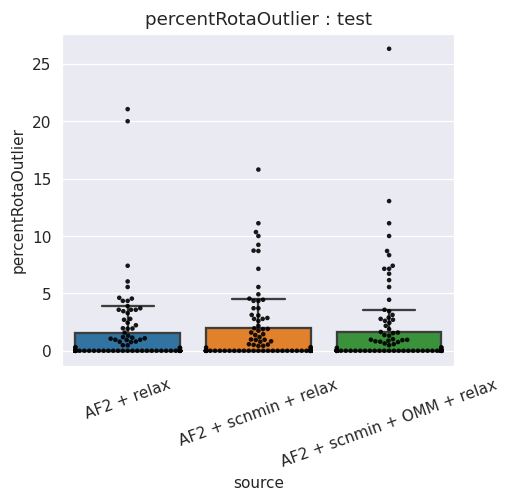

In [30]:
make_dual_plot('percentRotaOutlier')

# KDE Plots (2)

(-20.0, 110.0)

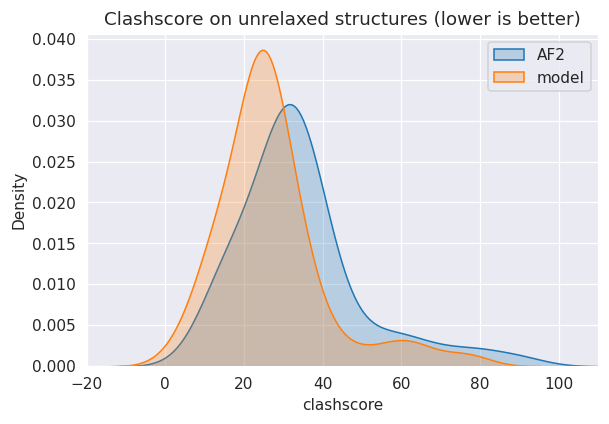

In [31]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["clashscore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["clashscore"],  fill=True, ax=ax, label="model")
plt.legend()
plt.title("Clashscore on unrelaxed structures (lower is better)")
plt.xlim(-20, 110)

(-20.0, 110.0)

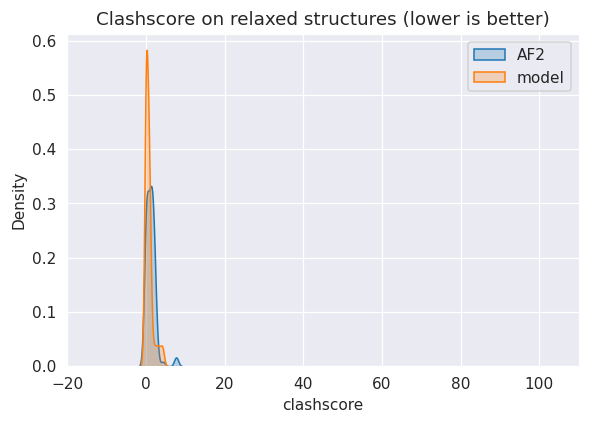

In [32]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["clashscore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["clashscore"],  fill=True, ax=ax, label="model")
plt.legend()
plt.title("Clashscore on relaxed structures (lower is better)")
plt.xlim(-20, 110)

(0.0, 5.0)

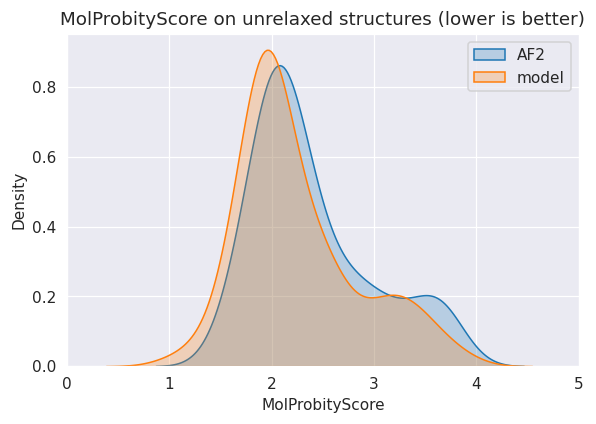

In [33]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["MolProbityScore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["MolProbityScore"],  fill=True, ax=ax, label="model")
plt.legend()
plt.title("MolProbityScore on unrelaxed structures (lower is better)")
plt.xlim(0, 5)

(0.0, 5.0)

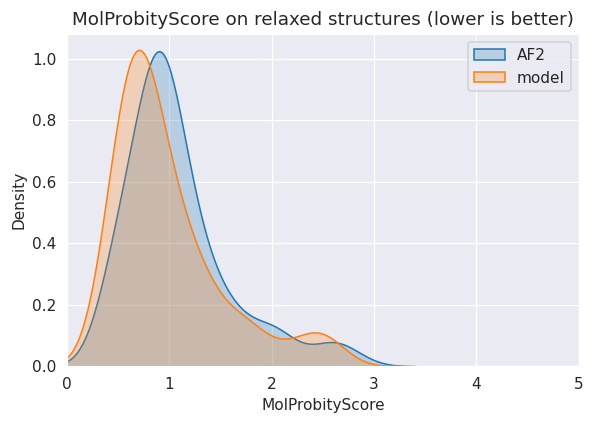

In [34]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["MolProbityScore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["MolProbityScore"],  fill=True, ax=ax, label="model")
plt.legend()
plt.title("MolProbityScore on relaxed structures (lower is better)")
plt.xlim(0, 5)

Text(0.5, 1.0, 'clashscore Percentile on unrelaxed structures (higher is better)')

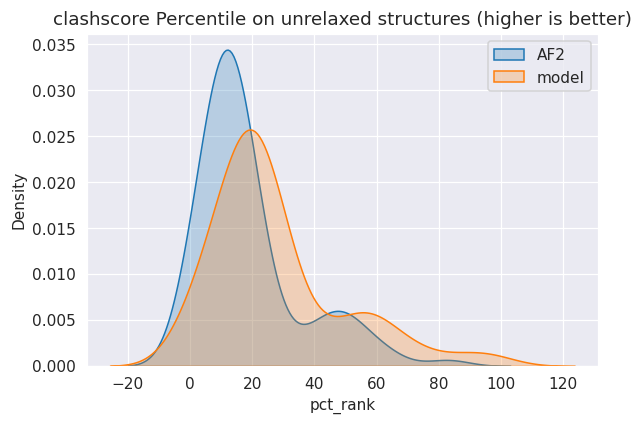

In [35]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["pct_rank"],  fill=True, ax=ax, label="model")
plt.legend()
plt.title("clashscore Percentile on unrelaxed structures (higher is better)")
# plt.xlim(-3, 20)

Text(0.5, 1.0, 'clashscore Percentile on relaxed structures (higher is better)')

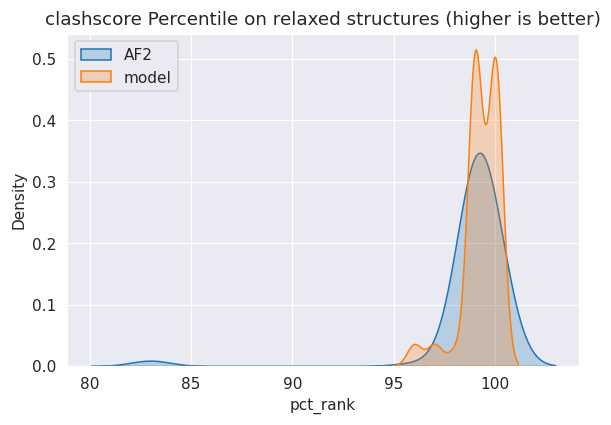

In [36]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["pct_rank"],  fill=True, ax=ax, label="model")
plt.legend(loc=2)
plt.title("clashscore Percentile on relaxed structures (higher is better)")
# plt.xlim(-3, 20)

Text(0.5, 1.0, 'MolProbityScore Percentile on unrelaxed structures (higher is better)')

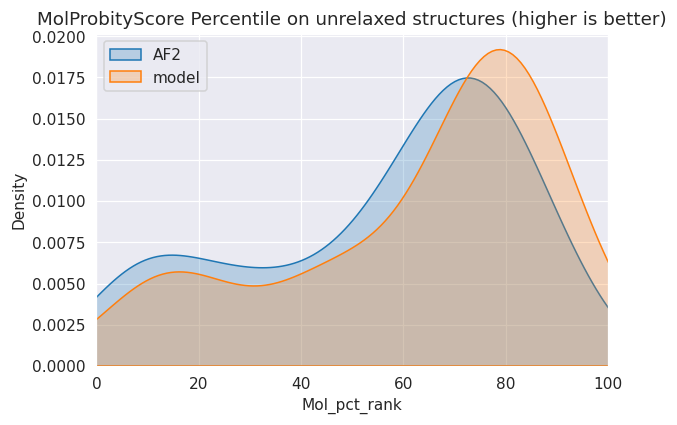

In [37]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["Mol_pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["Mol_pct_rank"],  fill=True, ax=ax, label="model")
# put the legend top left, not top right (default)
plt.legend(loc=2)
plt.xlim(0, 100)

plt.title("MolProbityScore Percentile on unrelaxed structures (higher is better)")

Text(0.5, 1.0, 'MolProbityScore Percentile on relaxed structures (higher is better)')

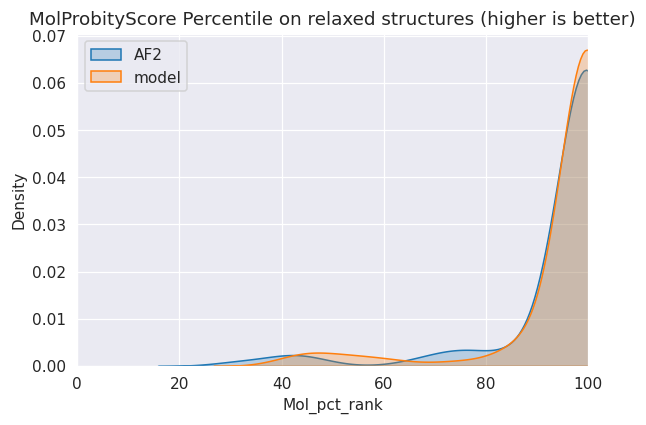

In [38]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["Mol_pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["Mol_pct_rank"],  fill=True, ax=ax, label="model")
# put the legend top left, not top right (default)
plt.legend(loc=2)
plt.xlim(0, 100)

plt.title("MolProbityScore Percentile on relaxed structures (higher is better)")

# KDE Plots (3 groups)

(0.0, 110.0)

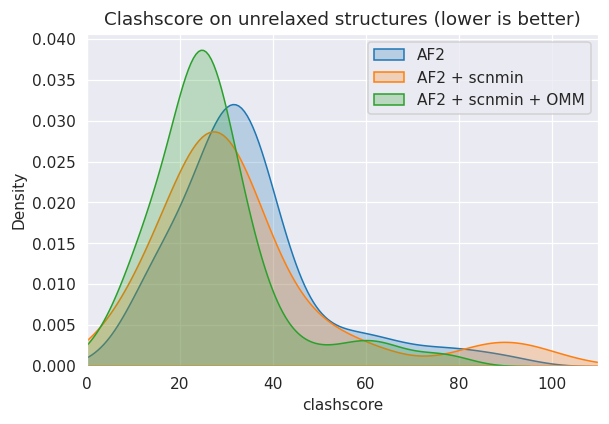

In [39]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["clashscore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred")]["clashscore"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["clashscore"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("Clashscore on unrelaxed structures (lower is better)")
plt.xlim(0, 110)

Text(0.5, 1.0, 'Clashscore on relaxed structures (lower is better)')

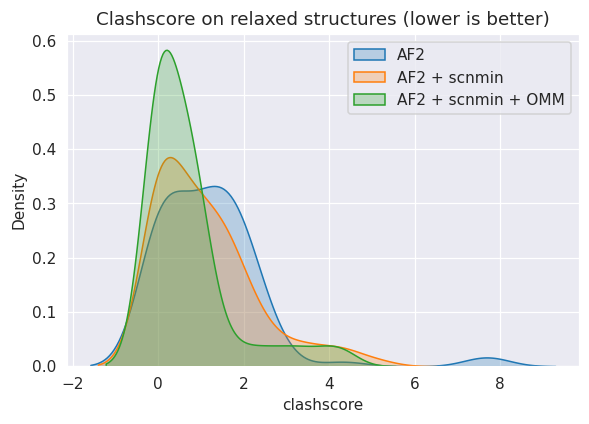

In [40]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["clashscore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["clashscore"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["clashscore"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("Clashscore on relaxed structures (lower is better)")
# plt.xlim(-20, 110)

Text(0.5, 1.0, 'MolProbityScore on unrelaxed structures (lower is better)')

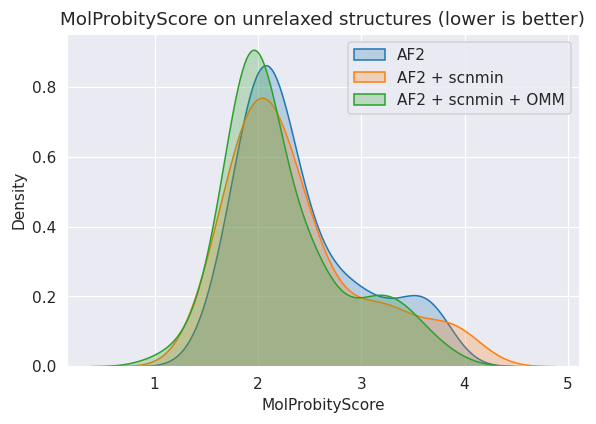

In [41]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["MolProbityScore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred")]["MolProbityScore"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["MolProbityScore"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("MolProbityScore on unrelaxed structures (lower is better)")


Text(0.5, 1.0, 'MolProbityScore on relaxed structures (lower is better)')

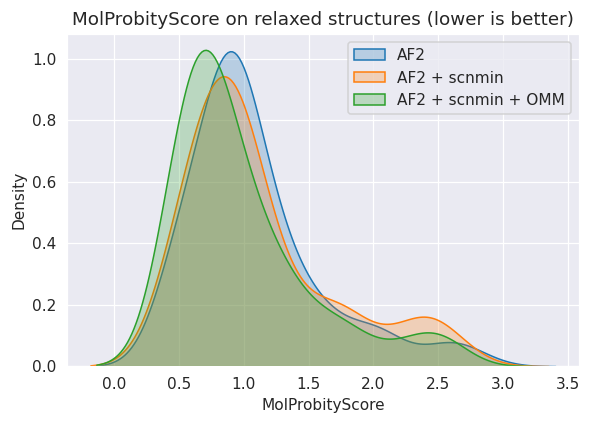

In [42]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["MolProbityScore"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["MolProbityScore"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["MolProbityScore"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("MolProbityScore on relaxed structures (lower is better)")


Text(0.5, 1.0, 'clashscore Percentile on unrelaxed structures (higher is better)')

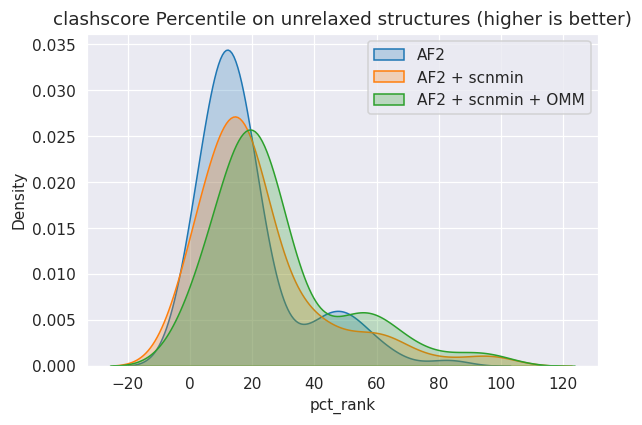

In [43]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred")]["pct_rank"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["pct_rank"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("clashscore Percentile on unrelaxed structures (higher is better)")


Text(0.5, 1.0, 'clashscore Percentile on relaxed structures (higher is better)')

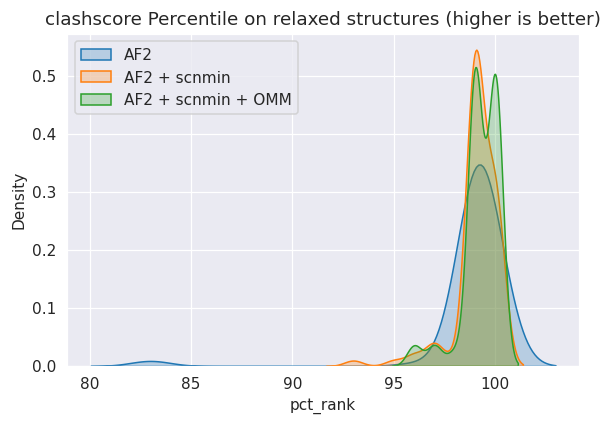

In [44]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["pct_rank"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["pct_rank"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend(loc=2)
plt.title("clashscore Percentile on relaxed structures (higher is better)")


Text(0.5, 1.0, 'MolProbityScore Percentile on unrelaxed structures (higher is better)')

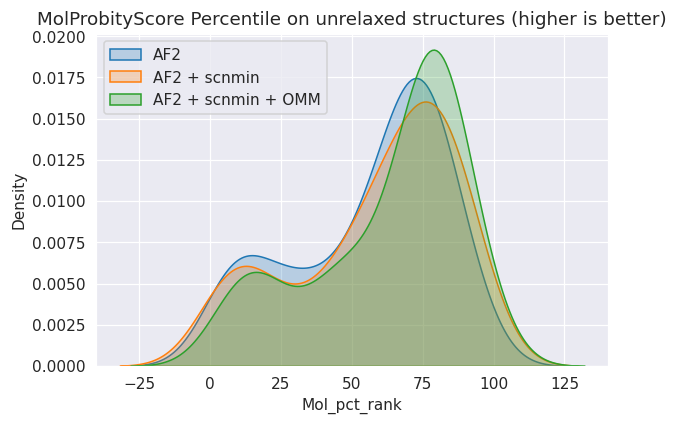

In [45]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["Mol_pct_rank"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred")]["Mol_pct_rank"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["Mol_pct_rank"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend(loc=2)
plt.title("MolProbityScore Percentile on unrelaxed structures (higher is better)")


Text(0.5, 1.0, 'MolProbityScore Percentile on relaxed structures (higher is better)')

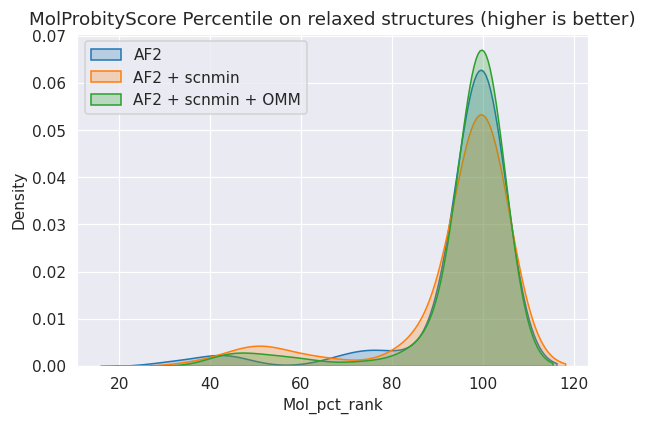

In [46]:
ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["Mol_pct_rank"],  fill=True,ax=ax, label="AF2", bw_adjust=1)
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["Mol_pct_rank"],  fill=True,ax=ax, label="AF2 + scnmin", bw_adjust=1)
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["Mol_pct_rank"],  fill=True, ax=ax, label="AF2 + scnmin + OMM", bw_adjust=1)
plt.legend(loc=2)
plt.title("MolProbityScore Percentile on relaxed structures (higher is better)")


Text(0.5, 1.0, 'relaxation_time (lower is better)')

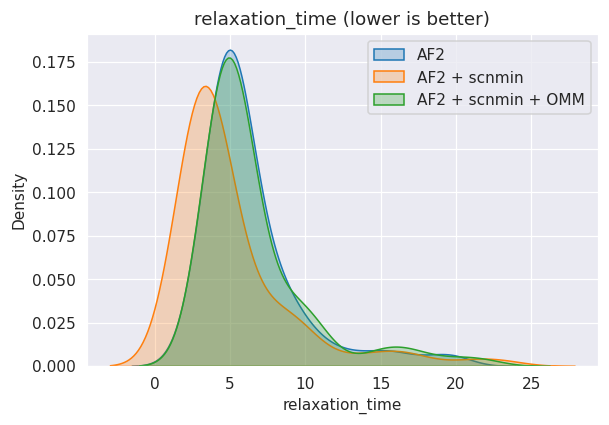

In [47]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["relaxation_time"],  fill=True,ax=ax, label="AF2", bw_adjust=1)
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["relaxation_time"],  fill=True,ax=ax, label="AF2 + scnmin", bw_adjust=1)
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["relaxation_time"],  fill=True, ax=ax, label="AF2 + scnmin + OMM", bw_adjust=1)
plt.legend()
plt.title("relaxation_time (lower is better)")


Text(0.5, 1.0, 'percentRotaOutlier on unrelaxed structures (lower is better)')

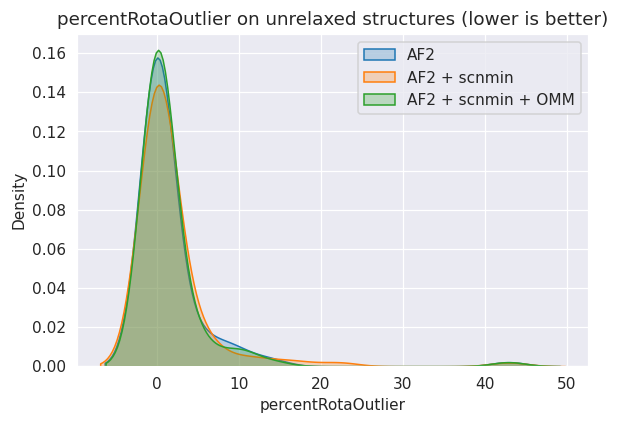

In [48]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred")]["percentRotaOutlier"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred")]["percentRotaOutlier"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred")]["percentRotaOutlier"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("percentRotaOutlier on unrelaxed structures (lower is better)")


Text(0.5, 1.0, 'percentRotaOutlier on relaxed structures (lower is better)')

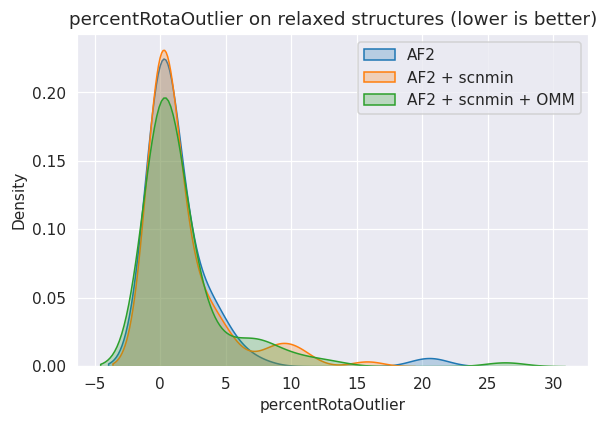

In [49]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["percentRotaOutlier"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["percentRotaOutlier"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["percentRotaOutlier"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("percentRotaOutlier on relaxed structures (lower is better)")


Text(0.5, 1.0, 'percentRamaOutlier on relaxed structures (lower is better)')

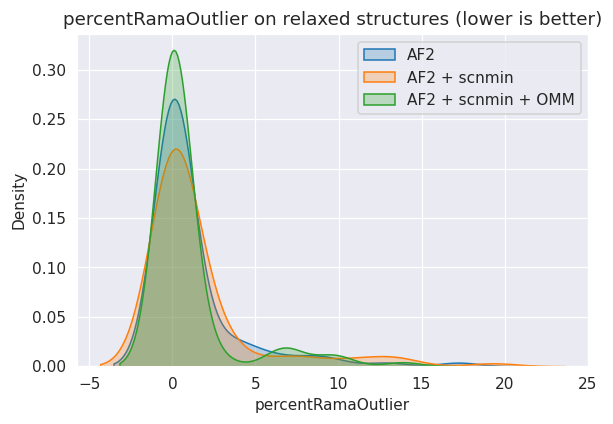

In [50]:
# Disable transparent background
plt.rcParams["figure.facecolor"] = 'white'

ax = plt.axes()
sns.kdeplot(df_dict[(af2, "test", "pred_relaxed")]["percentRamaOutlier"],  fill=True,ax=ax, label="AF2")
sns.kdeplot(df_dict[(af2_scnmin, "test", "pred_relaxed")]["percentRamaOutlier"],  fill=True,ax=ax, label="AF2 + scnmin")
sns.kdeplot(df_dict[(omm_scnmin, "test", "pred_relaxed")]["percentRamaOutlier"],  fill=True, ax=ax, label="AF2 + scnmin + OMM")
plt.legend()
plt.title("percentRamaOutlier on relaxed structures (lower is better)")


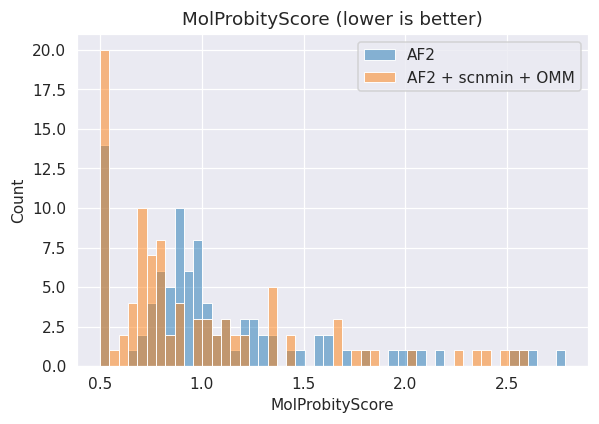

In [51]:
# Set the number of bins
num_bins = 50

# Get the data for both distributions
baseline_data = df_dict[(af2, "test", "pred_relaxed")]["MolProbityScore"]
model_data = df_dict[(omm_scnmin, "test", "pred_relaxed")]["MolProbityScore"]

# Calculate the bin edges using numpy.histogram
bin_edges = np.histogram(np.concatenate([baseline_data, model_data]), bins=num_bins)[1]

ax = plt.axes()

# Plot the histograms using the calculated bin edges
sns.histplot(baseline_data, bins=bin_edges, fill=True, ax=None, label="AF2", alpha=0.5)
sns.histplot(model_data, bins=bin_edges, fill=True, ax=None, label="AF2 + scnmin + OMM", alpha=0.5, color='tab:orange')
# plt.show()


# Put the legend top left, not top right (default)
plt.legend()
plt.title("MolProbityScore (lower is better)")

plt.show()

In [52]:
# # Set the number of bins
# num_bins = 30

# # Get the data for both distributions
# baseline_data = df_dict[(baseline, "test", "pred_relaxed")]["Mol_pct_rank"]
# model_data = df_dict[(model, "test", "pred_relaxed")]["Mol_pct_rank"]

# # Calculate the bin edges using numpy.histogram
# bin_edges = np.histogram(np.concatenate([baseline_data, model_data]), bins=num_bins)[1]

# ax = plt.axes()

# # Plot the histograms using the calculated bin edges
# sns.histplot(model_data, bins=bin_edges, fill=True, ax=ax, label="model", alpha=0.5, color='tab:orange')
# sns.histplot(baseline_data, bins=bin_edges, fill=True, ax=ax, label="AF2", alpha=0.5)

# # Put the legend top left, not top right (default)
# plt.legend(loc=2)
# plt.title("MolProbityScore Percentile (higher is better)")

# plt.show()